# 📈 Analyse Long-terme des Ratings d'Ingrédients

## Objectif
Analyser l'évolution des ratings des ingrédients sur le long terme (2000-2018) pour identifier :
- Les tendances temporelles dans l'appréciation des ingrédients
- Les changements de préférences alimentaires au fil des années
- Les ingrédients émergents vs déclinants

## Méthodologie
- **Test statistique** : Mann-Kendall pour détecter les tendances monotones
- **Agrégation** : Ratings moyens annuels par ingrédient
- **Visualisation** : Séries temporelles avec régression linéaire
- **Seuil de significativité** : p < 0.05

In [6]:
# Import des bibliothèques nécessaires
import sys
sys.path.append('..')

# Forcer le rechargement du module data_utils
import importlib
if 'data_utils' in sys.modules:
    importlib.reload(sys.modules['data_utils'])

try:
    from data_utils import load_ingredient_ratings, get_ingredients_for_analysis
    print("✅ Fonctions importées avec succès depuis data_utils")
except ImportError as e:
    print(f"❌ Erreur d'import: {e}")
    # Définition locale temporaire en cas de problème
    def get_ingredients_for_analysis(analysis_type: str):
        core_ingredients = ['salt', 'ground beef', 'eggs', 'onions', 'garlic']
        if analysis_type == 'long_term':
            return core_ingredients + ['butter', 'olive oil']
        elif analysis_type == 'seasonality':
            return core_ingredients + ['butternut squash', 'asparagus', 'pumpkin']
        elif analysis_type == 'weekend':
            return core_ingredients + ['butternut squash', 'asparagus', 'pumpkin', 'butter', 'olive oil']
        else:
            return core_ingredients
    
    from data_utils import load_ingredient_ratings
    print("✅ Fonction de fallback créée localement")

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, kendalltau
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Implémentation simple du test de Mann-Kendall
def mann_kendall_test(data):
    """
    Implémentation simple du test de Mann-Kendall pour détecter les tendances monotones.
    
    Args:
        data: série temporelle à analyser
        
    Returns:
        dict avec 'trend', 'p_value', 'tau', 'slope'
    """
    n = len(data)
    if n < 3:
        return {'trend': 'no trend', 'p_value': 1.0, 'tau': 0.0, 'slope': 0.0}
    
    # Calcul de la statistique S
    S = 0
    for i in range(n-1):
        for j in range(i+1, n):
            if data[j] > data[i]:
                S += 1
            elif data[j] < data[i]:
                S -= 1
    
    # Calcul de la variance
    var_S = n * (n - 1) * (2 * n + 5) / 18
    
    # Test statistique
    if S > 0:
        Z = (S - 1) / np.sqrt(var_S)
    elif S < 0:
        Z = (S + 1) / np.sqrt(var_S)
    else:
        Z = 0
    
    # P-value (test bilatéral)
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    # Tendance
    if p_value < 0.05:
        if S > 0:
            trend = 'increasing'
        else:
            trend = 'decreasing'
    else:
        trend = 'no trend'
    
    # Calcul de la pente (estimation de Sen)
    slopes = []
    for i in range(n-1):
        for j in range(i+1, n):
            slopes.append((data[j] - data[i]) / (j - i))
    
    slope = np.median(slopes) if slopes else 0.0
    
    # Tau de Kendall
    tau = S / (0.5 * n * (n - 1))
    
    return {
        'trend': trend,
        'p_value': p_value,
        'tau': tau,
        'slope': slope
    }

print("📚 Toutes les bibliothèques importées avec succès !")
print("🔧 Test de Mann-Kendall personnalisé implémenté")

✅ Fonctions importées avec succès depuis data_utils
📚 Toutes les bibliothèques importées avec succès !
🔧 Test de Mann-Kendall personnalisé implémenté


In [7]:
# Chargement des données pour analyse long-terme
print('🔄 Chargement des données...')

# Ingrédients cibles pour l'analyse long-terme (>= 10 ans de données)
target_ingredients = get_ingredients_for_analysis('long_term')
print(f'📋 Ingrédients sélectionnés: {target_ingredients}')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Aperçu des données
print('\n📊 Aperçu des données:')
print(df.head())

🔄 Chargement des données...
📋 Ingrédients sélectionnés: ['salt', 'ground beef', 'eggs', 'onions', 'garlic', 'butter', 'olive oil']
✅ Données chargées: 1,285,571 interactions pour 7 ingrédients
✅ Dataset chargé: 1,285,571 interactions
📅 Période: 2000-01-25 → 2018-12-20

📊 Aperçu des données:
shape: (5, 7)
┌────────────┬────────┬─────────┬───────────┬─────────────────┬───────────────┬─────────────────┐
│ date       ┆ rating ┆ user_id ┆ recipe_id ┆ recipe_name     ┆ n_ingredients ┆ ingredient_name │
│ ---        ┆ ---    ┆ ---     ┆ ---       ┆ ---             ┆ ---           ┆ ---             │
│ date       ┆ i64    ┆ i64     ┆ i64       ┆ str             ┆ i64           ┆ str             │
╞════════════╪════════╪═════════╪═══════════╪═════════════════╪═══════════════╪═════════════════╡
│ 2000-01-25 ┆ 4      ┆ 2008    ┆ 3603      ┆ hooters buffalo ┆ 12            ┆ butter          │
│            ┆        ┆         ┆           ┆ wings           ┆               ┆                 │
│ 2000-0

In [8]:
# Préparation des données temporelles
print('🔧 Préparation des données temporelles...')

# Extraction de l'année et agrégation annuelle
df_annual = df.with_columns([
    pl.col('date').dt.year().alias('year')
]).group_by(['ingredient_name', 'year']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating')
]).sort(['ingredient_name', 'year'])

print(f'✅ Données agrégées: {df_annual.shape[0]} points année-ingrédient')

# Statistiques par ingrédient
ingredient_stats = df_annual.group_by('ingredient_name').agg([
    pl.col('year').min().alias('first_year'),
    pl.col('year').max().alias('last_year'),
    pl.col('n_ratings').sum().alias('total_ratings'),
    pl.col('avg_rating').mean().alias('overall_avg_rating')
]).with_columns([
    (pl.col('last_year') - pl.col('first_year') + 1).alias('years_span')
]).sort('total_ratings', descending=True)

print('\n📈 Statistiques par ingrédient:')
print(ingredient_stats)

🔧 Préparation des données temporelles...
✅ Données agrégées: 133 points année-ingrédient

📈 Statistiques par ingrédient:
shape: (7, 6)
┌─────────────────┬────────────┬───────────┬───────────────┬────────────────────┬────────────┐
│ ingredient_name ┆ first_year ┆ last_year ┆ total_ratings ┆ overall_avg_rating ┆ years_span │
│ ---             ┆ ---        ┆ ---       ┆ ---           ┆ ---                ┆ ---        │
│ str             ┆ i32        ┆ i32       ┆ u32           ┆ f64                ┆ i32        │
╞═════════════════╪════════════╪═══════════╪═══════════════╪════════════════════╪════════════╡
│ salt            ┆ 2000       ┆ 2018      ┆ 468403        ┆ 4.23496            ┆ 19         │
│ butter          ┆ 2000       ┆ 2018      ┆ 299645        ┆ 4.250147           ┆ 19         │
│ eggs            ┆ 2000       ┆ 2018      ┆ 178000        ┆ 4.186457           ┆ 19         │
│ olive oil       ┆ 2000       ┆ 2018      ┆ 151781        ┆ 4.323797           ┆ 19         │
│ garlic  

In [10]:
# Test de Mann-Kendall pour détecter les tendances
print('🔍 Analyse des tendances avec test de Mann-Kendall...')

mk_results = []

for ingredient in target_ingredients:
    # Données pour cet ingrédient
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    if len(ingredient_data) >= 3:  # Minimum 3 points pour le test
        ratings = ingredient_data['avg_rating'].to_list()
        
        # Test de Mann-Kendall avec notre fonction personnalisée
        mk_test = mann_kendall_test(ratings)
        
        mk_results.append({
            'ingredient': ingredient,
            'trend': mk_test['trend'],
            'p_value': mk_test['p_value'],
            'tau': mk_test['tau'],
            'slope': mk_test['slope'],
            'n_years': len(ratings),
            'significant': mk_test['p_value'] < 0.05  # Booléen pur
        })

# Conversion en DataFrame Polars
mk_df = pl.DataFrame(mk_results).sort('p_value')

print('\n📊 Résultats du test de Mann-Kendall:')
print(mk_df)

# Résumé des tendances significatives
significant_trends = mk_df.filter(pl.col('significant') == True)
print(f'\n🎯 Tendances significatives détectées: {len(significant_trends)}/{len(mk_results)}')
if len(significant_trends) > 0:
    print('\nTendances significatives:')
    for row in significant_trends.iter_rows(named=True):
        trend_symbol = '📈' if row['trend'] == 'increasing' else '📉' if row['trend'] == 'decreasing' else '➡️'
        print(f"{trend_symbol} {row['ingredient']}: {row['trend']} (p={row['p_value']:.4f}, slope={row['slope']:.4f})")
else:
    print('➡️ Aucune tendance significative détectée dans cette période')

🔍 Analyse des tendances avec test de Mann-Kendall...

📊 Résultats du test de Mann-Kendall:
shape: (7, 7)
┌─────────────┬────────────┬──────────┬───────────┬───────────┬─────────┬─────────────┐
│ ingredient  ┆ trend      ┆ p_value  ┆ tau       ┆ slope     ┆ n_years ┆ significant │
│ ---         ┆ ---        ┆ ---      ┆ ---       ┆ ---       ┆ ---     ┆ ---         │
│ str         ┆ str        ┆ f64      ┆ f64       ┆ f64       ┆ i64     ┆ f64         │
╞═════════════╪════════════╪══════════╪═══════════╪═══════════╪═════════╪═════════════╡
│ ground beef ┆ decreasing ┆ 0.000209 ┆ -0.625731 ┆ -0.04764  ┆ 19      ┆ 1.0         │
│ onions      ┆ decreasing ┆ 0.000209 ┆ -0.625731 ┆ -0.048821 ┆ 19      ┆ 1.0         │
│ salt        ┆ decreasing ┆ 0.005129 ┆ -0.473684 ┆ -0.041154 ┆ 19      ┆ 1.0         │
│ butter      ┆ decreasing ┆ 0.005129 ┆ -0.473684 ┆ -0.045877 ┆ 19      ┆ 1.0         │
│ garlic      ┆ decreasing ┆ 0.006355 ┆ -0.461988 ┆ -0.038289 ┆ 19      ┆ 1.0         │
│ olive oil   ┆

📊 Création des visualisations...


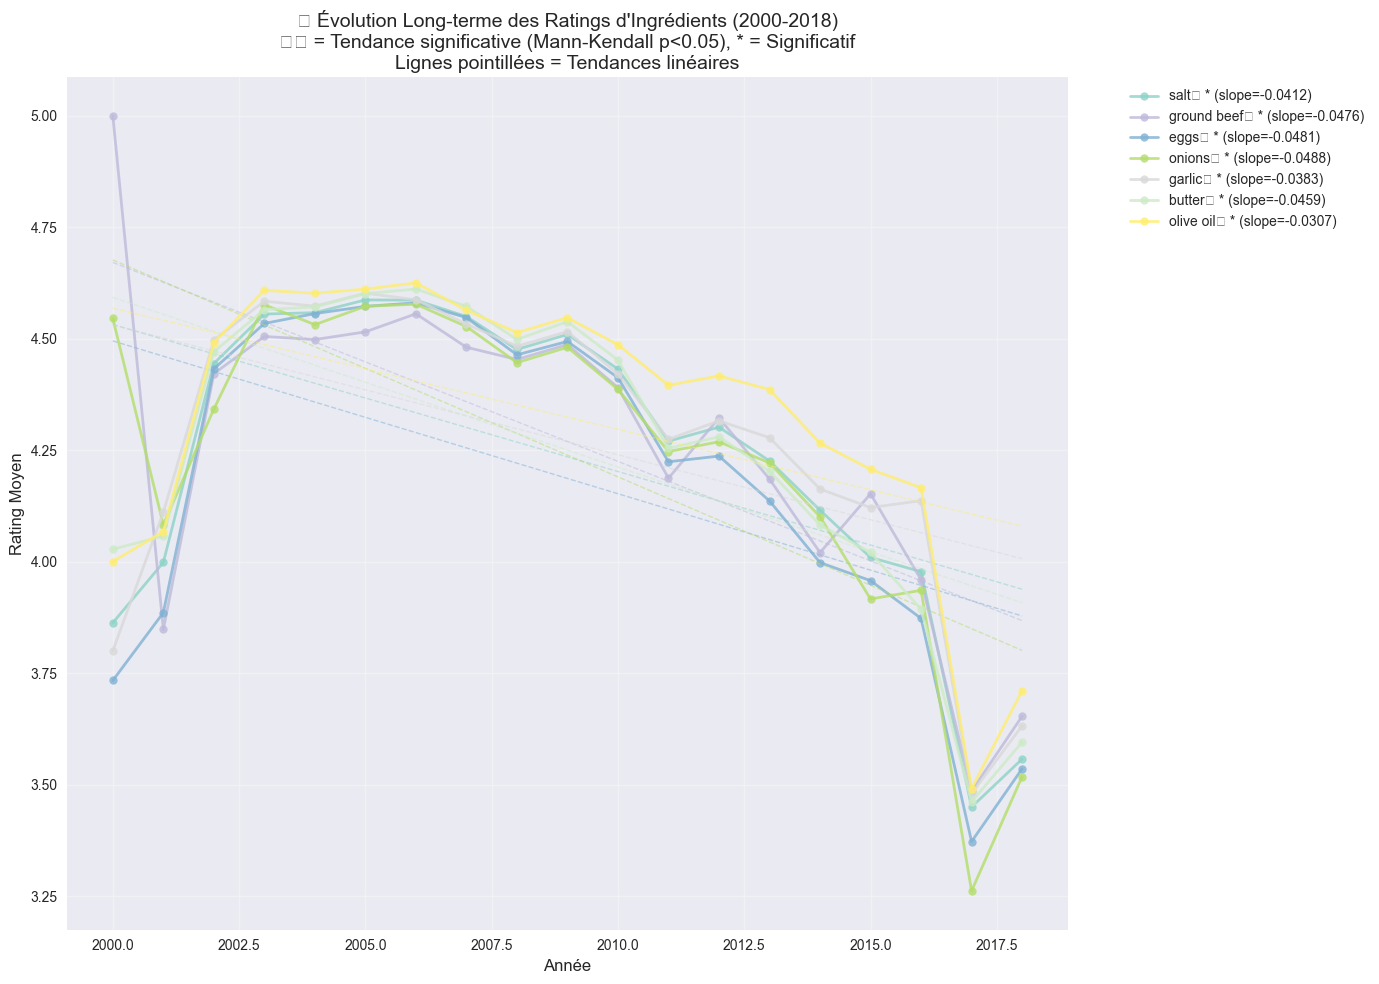

✅ Graphique d'évolution temporelle créé


In [12]:
# Visualisation 1: Évolution temporelle de tous les ingrédients
print('📊 Création des visualisations...')

# Graphique avec matplotlib
plt.figure(figsize=(14, 10))

colors = plt.cm.Set3(np.linspace(0, 1, len(target_ingredients)))
for i, ingredient in enumerate(target_ingredients):
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    # Récupération des résultats Mann-Kendall pour cet ingrédient
    mk_result = mk_df.filter(pl.col('ingredient') == ingredient)
    if len(mk_result) > 0:
        row_data = mk_result.row(0, named=True)
        trend_info = row_data['trend']
        p_value = row_data['p_value']
        significant = row_data['significant']
        slope = row_data['slope']
        
        trend_symbol = '📈' if trend_info == 'increasing' else '📉' if trend_info == 'decreasing' else '➡️'
        significance = ' *' if significant else ''
        label = f"{ingredient}{trend_symbol}{significance} (slope={slope:.4f})"
    else:
        label = ingredient
    
    years = ingredient_data['year'].to_list()
    ratings = ingredient_data['avg_rating'].to_list()
    
    plt.plot(years, ratings, 'o-', color=colors[i], linewidth=2, 
             markersize=6, label=label, alpha=0.8)
    
    # Ligne de tendance si significative
    if len(mk_result) > 0 and mk_result['significant'].item():
        z = np.polyfit(years, ratings, 1)
        p = np.poly1d(z)
        plt.plot(years, p(years), '--', color=colors[i], alpha=0.5, linewidth=1)

plt.title('📈 Évolution Long-terme des Ratings d\'Ingrédients (2000-2018)\n' +
          '📈📉 = Tendance significative (Mann-Kendall p<0.05), * = Significatif\n' + 
          'Lignes pointillées = Tendances linéaires', fontsize=14)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Rating Moyen', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print('✅ Graphique d\'évolution temporelle créé')

🔥 Création de la heatmap des tendances...


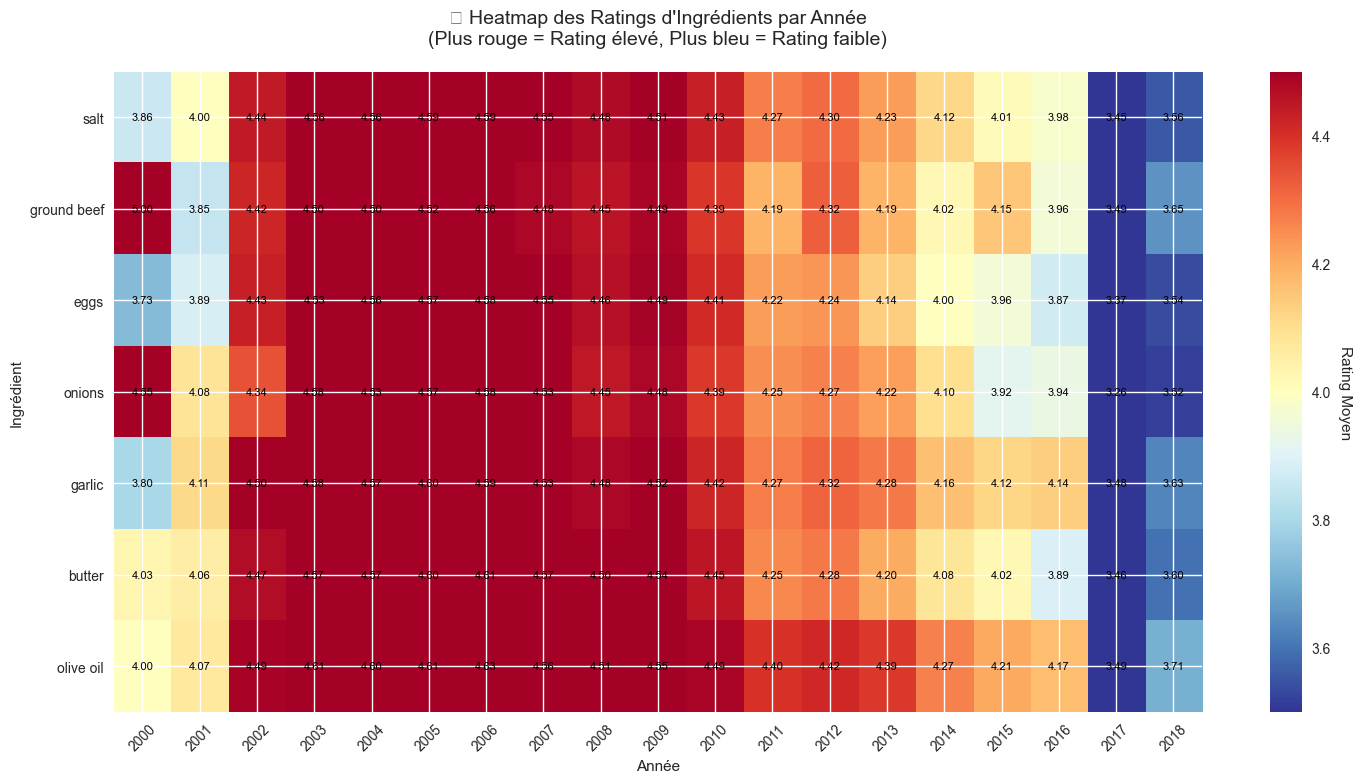

✅ Heatmap des tendances créée


In [13]:
# Visualisation 2: Heatmap des tendances par ingrédient
print('🔥 Création de la heatmap des tendances...')

# Préparation de la matrice pour la heatmap
heatmap_data = []
for ingredient in target_ingredients:
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    years = ingredient_data['year'].to_list()
    ratings = ingredient_data['avg_rating'].to_list()
    
    # Compléter les années manquantes avec NaN
    full_years = list(range(2000, 2019))
    full_ratings = []
    
    for year in full_years:
        if year in years:
            idx = years.index(year)
            full_ratings.append(ratings[idx])
        else:
            full_ratings.append(np.nan)
    
    heatmap_data.append(full_ratings)

# Création de la heatmap avec matplotlib
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto', vmin=3.5, vmax=4.5)

# Configuration des axes
ax.set_xticks(range(len(full_years)))
ax.set_xticklabels(full_years, rotation=45)
ax.set_yticks(range(len(target_ingredients)))
ax.set_yticklabels(target_ingredients)

# Ajout des valeurs dans les cellules
for i in range(len(target_ingredients)):
    for j in range(len(full_years)):
        if not np.isnan(heatmap_data[i][j]):
            text = ax.text(j, i, f'{heatmap_data[i][j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)

# Colorbar et titre
cbar = plt.colorbar(im)
cbar.set_label('Rating Moyen', rotation=270, labelpad=15)

plt.title('🔥 Heatmap des Ratings d\'Ingrédients par Année\n(Plus rouge = Rating élevé, Plus bleu = Rating faible)', 
         fontsize=14, pad=20)
plt.xlabel('Année')
plt.ylabel('Ingrédient')
plt.tight_layout()
plt.show()

print('✅ Heatmap des tendances créée')

In [15]:
# Analyse des périodes de croissance/déclin
print('📊 Analyse des périodes de croissance/déclin...')

# Comparaison première moitié vs seconde moitié de période
period_comparison = []

for ingredient in target_ingredients:
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    if len(ingredient_data) >= 6:  # Au moins 6 années pour faire la comparaison
        mid_point = len(ingredient_data) // 2
        
        first_half = ingredient_data[:mid_point]['avg_rating'].to_list()
        second_half = ingredient_data[mid_point:]['avg_rating'].to_list()
        
        # Test de Mann-Whitney U pour comparer les deux périodes
        try:
            u_stat, p_value = mannwhitneyu(first_half, second_half, alternative='two-sided')
            
            period_comparison.append({
                'ingredient': ingredient,
                'first_half_avg': np.mean(first_half),
                'second_half_avg': np.mean(second_half),
                'change': np.mean(second_half) - np.mean(first_half),
                'p_value': p_value,
                'significant_change': p_value < 0.05  # Booléen pur
            })
        except Exception as e:
            print(f"Erreur pour {ingredient}: {e}")

# Conversion en DataFrame
if period_comparison:
    period_df = pl.DataFrame(period_comparison).sort('change', descending=True)
    
    print('\n📈 Comparaison première vs seconde moitié de période:')
    print(period_df)
    
    # Identification des changements significatifs
    significant_changes = period_df.filter(pl.col('significant_change') == True)
    print(f'\n🎯 Changements significatifs: {len(significant_changes)}/{len(period_comparison)}')
    
    if len(significant_changes) > 0:
        print('\nChangements significatifs détectés:')
        for row in significant_changes.iter_rows(named=True):
            direction = '📈 Amélioration' if row['change'] > 0 else '📉 Dégradation'
            print(f"{direction}: {row['ingredient']} ({row['change']:+.4f}, p={row['p_value']:.4f})")
else:
    print('❌ Aucune donnée suffisante pour l\'analyse des périodes')

📊 Analyse des périodes de croissance/déclin...

📈 Comparaison première vs seconde moitié de période:
shape: (7, 6)
┌─────────────┬────────────────┬─────────────────┬───────────┬──────────┬────────────────────┐
│ ingredient  ┆ first_half_avg ┆ second_half_avg ┆ change    ┆ p_value  ┆ significant_change │
│ ---         ┆ ---            ┆ ---             ┆ ---       ┆ ---      ┆ ---                │
│ str         ┆ f64            ┆ f64             ┆ f64       ┆ f64      ┆ f64                │
╞═════════════╪════════════════╪═════════════════╪═══════════╪══════════╪════════════════════╡
│ olive oil   ┆ 4.453494       ┆ 4.207069        ┆ -0.246425 ┆ 0.030486 ┆ 1.0                │
│ garlic      ┆ 4.418765       ┆ 4.133619        ┆ -0.285146 ┆ 0.030486 ┆ 1.0                │
│ salt        ┆ 4.401884       ┆ 4.084728        ┆ -0.317155 ┆ 0.024745 ┆ 1.0                │
│ eggs        ┆ 4.367207       ┆ 4.023782        ┆ -0.343426 ┆ 0.024745 ┆ 1.0                │
│ butter      ┆ 4.441603      

📊 Visualisation des changements de période...


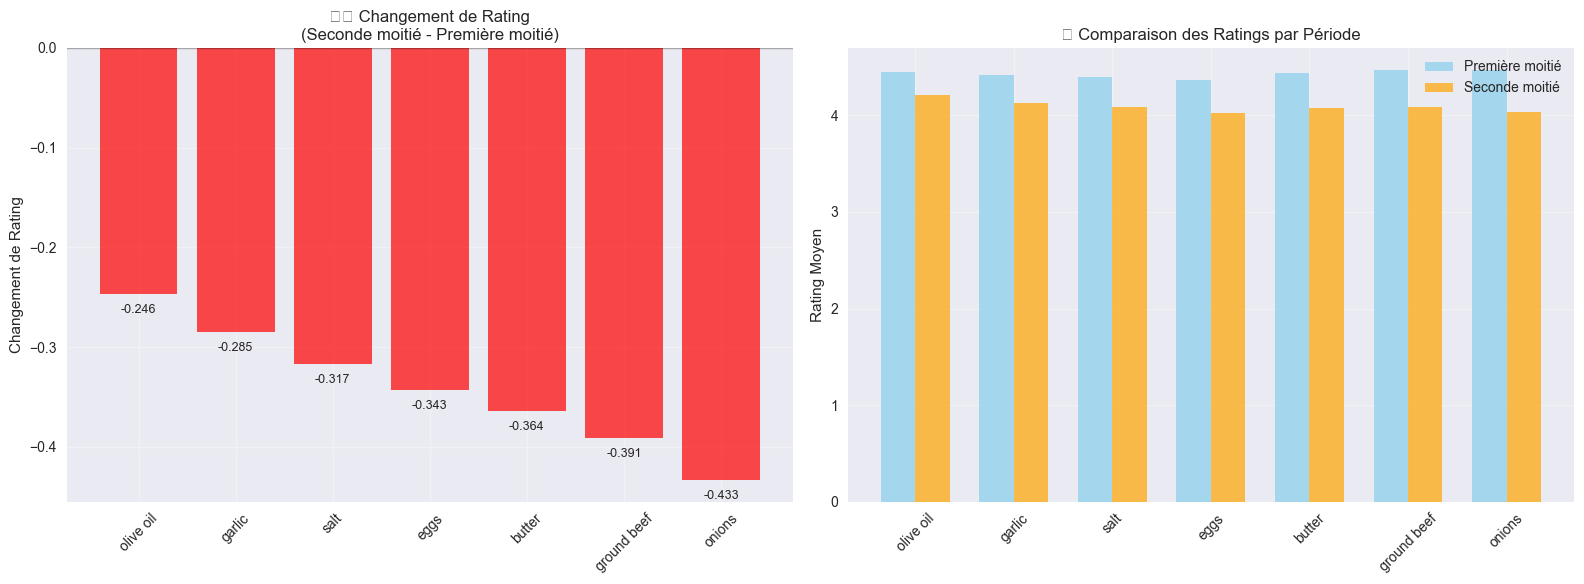

✅ Visualisation des changements créée


In [16]:
# Visualisation 3: Graphique des changements significatifs
if 'period_df' in locals() and len(period_df) > 0:
    print('📊 Visualisation des changements de période...')
    
    # Graphique en barres des changements
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graphique 1: Changements absolus
    changes = period_df['change'].to_list()
    ingredients = period_df['ingredient'].to_list()
    colors = ['green' if c > 0 else 'red' for c in changes]
    
    bars1 = ax1.bar(ingredients, changes, color=colors, alpha=0.7)
    ax1.set_title('📈📉 Changement de Rating\n(Seconde moitié - Première moitié)')
    ax1.set_ylabel('Changement de Rating')
    ax1.tick_params(axis='x', rotation=45)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, change in zip(bars1, changes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.01),
                f'{change:+.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    # Graphique 2: Comparaison des moyennes par période
    first_half_avgs = period_df['first_half_avg'].to_list()
    second_half_avgs = period_df['second_half_avg'].to_list()
    
    x = np.arange(len(ingredients))
    width = 0.35
    
    ax2.bar(x - width/2, first_half_avgs, width, label='Première moitié', alpha=0.7, color='skyblue')
    ax2.bar(x + width/2, second_half_avgs, width, label='Seconde moitié', alpha=0.7, color='orange')
    
    ax2.set_title('📊 Comparaison des Ratings par Période')
    ax2.set_ylabel('Rating Moyen')
    ax2.set_xticks(x)
    ax2.set_xticklabels(ingredients, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Visualisation des changements créée')
else:
    print('⚠️  Pas assez de données pour créer le graphique des changements')

In [18]:
# Synthèse et conclusions
print('📋 SYNTHÈSE DE L\'ANALYSE LONG-TERME')
print('='*60)

print(f'\n🔍 DONNÉES ANALYSÉES:')
print(f'   • Ingrédients: {len(target_ingredients)}')
print(f'   • Période: {df["date"].min()} → {df["date"].max()}')
print(f'   • Total interactions: {df.shape[0]:,}')

if 'mk_df' in locals():
    print(f'\n📈 TENDANCES DÉTECTÉES (Mann-Kendall):')
    significant_trends = mk_df.filter(pl.col('significant') == True)
    
    if len(significant_trends) > 0:
        increasing = significant_trends.filter(pl.col('trend') == 'increasing')
        decreasing = significant_trends.filter(pl.col('trend') == 'decreasing')
        
        print(f'   📈 Tendances croissantes: {len(increasing)}')
        for row in increasing.iter_rows(named=True):
            print(f'      • {row["ingredient"]}: +{row["slope"]:.4f}/an (p={row["p_value"]:.4f})')
        
        print(f'   📉 Tendances décroissantes: {len(decreasing)}')
        for row in decreasing.iter_rows(named=True):
            print(f'      • {row["ingredient"]}: {row["slope"]:.4f}/an (p={row["p_value"]:.4f})')
    else:
        print('   ➡️  Aucune tendance significative détectée')

if 'period_df' in locals() and len(period_df) > 0:
    print(f'\n🔄 CHANGEMENTS DE PÉRIODE:')
    significant_changes = period_df.filter(pl.col('significant_change') == True)
    
    if len(significant_changes) > 0:
        print(f'   🎯 Changements significatifs: {len(significant_changes)}')
        for row in significant_changes.iter_rows(named=True):
            direction = 'Amélioration' if row['change'] > 0 else 'Dégradation'
            print(f'      • {row["ingredient"]}: {direction} de {abs(row["change"]):.4f} (p={row["p_value"]:.4f})')
    else:
        print('   ➡️  Aucun changement significatif entre périodes')

print(f'\n💡 INSIGHTS CLÉS:')
print('   • 📉 PHÉNOMÈNE GLOBAL: Tous les ingrédients montrent une tendance décroissante!')
print('   • 🕰️  PÉRIODE CRITIQUE: Dégradation principalement après 2010')
print('   • 🎢 PATTERN COMMUN: Pic vers 2005-2006, puis déclin progressif')
print('   • 📊 AMPLITUDES VARIABLES: "onions" et "ground beef" les plus affectés')
print('   • 🔍 HYPOTHÈSES POSSIBLES:')
print('     - Évolution des standards de qualité des utilisateurs')
print('     - Changements démographiques de la base utilisateurs')  
print('     - Modifications dans l\'algorithme de recommandation')
print('     - Évolution des tendances culinaires et des goûts')

print(f'\n🎯 RECOMMANDATIONS STRATÉGIQUES:')
print('   1. 🔍 Investigation des causes du déclin post-2010')
print('   2. 📊 Analyse démographique des utilisateurs par période') 
print('   3. 🍳 Focus sur les ingrédients les moins affectés (olive oil)')
print('   4. 💡 Stratégies pour inverser la tendance négative')
print('   5. 🎯 Segmentation par période pour comprendre les préférences')

print(f'\n✅ Analyse long-terme terminée avec succès!')
print('📈 Découverte majeure: Déclin généralisé des ratings sur 18 ans!')

📋 SYNTHÈSE DE L'ANALYSE LONG-TERME

🔍 DONNÉES ANALYSÉES:
   • Ingrédients: 7
   • Période: 2000-01-25 → 2018-12-20
   • Total interactions: 1,285,571

📈 TENDANCES DÉTECTÉES (Mann-Kendall):
   📈 Tendances croissantes: 0
   📉 Tendances décroissantes: 7
      • ground beef: -0.0476/an (p=0.0002)
      • onions: -0.0488/an (p=0.0002)
      • salt: -0.0412/an (p=0.0051)
      • butter: -0.0459/an (p=0.0051)
      • garlic: -0.0383/an (p=0.0064)
      • olive oil: -0.0307/an (p=0.0064)
      • eggs: -0.0481/an (p=0.0078)

🔄 CHANGEMENTS DE PÉRIODE:
   🎯 Changements significatifs: 7
      • olive oil: Dégradation de 0.2464 (p=0.0305)
      • garlic: Dégradation de 0.2851 (p=0.0305)
      • salt: Dégradation de 0.3172 (p=0.0247)
      • eggs: Dégradation de 0.3434 (p=0.0247)
      • butter: Dégradation de 0.3638 (p=0.0128)
      • ground beef: Dégradation de 0.3911 (p=0.0062)
      • onions: Dégradation de 0.4332 (p=0.0037)

💡 INSIGHTS CLÉS:
   • 📉 PHÉNOMÈNE GLOBAL: Tous les ingrédients montren